In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping

from pathlib import Path
import os

DATA_DIR = Path('../data/processed')

Funciones adicionales:
Estimar RAM

In [28]:
# === CONFIGURACIONES RECOMENDADAS ===

# 🔴 RAM Limitada (8GB o menos)
if "limited_ram":
    SAMPLE_SIZE_FUNCTION_5 = 1_000      # Prueba rápida de funciones
    MAX_TRAIN_SAMPLES = 25_000          # Entrenamiento básico
    MAX_VAL_SAMPLES = 5_000             # Validación
    MAX_TEST_SAMPLES = 2_000            # Evaluación

# 🟡 RAM Moderada (16GB)
elif "moderate_ram":
    SAMPLE_SIZE_FUNCTION_5 = 5_000      # Prueba más robusta
    MAX_TRAIN_SAMPLES = 100_000         # ~0.4GB
    MAX_VAL_SAMPLES = 20_000            # ~80MB
    MAX_TEST_SAMPLES = 10_000           # ~40MB

# 🟢 RAM Alta (32GB+)
elif "high_ram":
    SAMPLE_SIZE_FUNCTION_5 = 10_000     # Prueba completa
    MAX_TRAIN_SAMPLES = 500_000         # ~2GB
    MAX_VAL_SAMPLES = 100_000           # ~400MB
    MAX_TEST_SAMPLES = 50_000           # ~200MB

# 🚀 Workstation/Servidor (64GB+)
elif "server_ram":
    SAMPLE_SIZE_FUNCTION_5 = 25_000     # Prueba exhaustiva
    MAX_TRAIN_SAMPLES = 2_000_000       # ~8GB
    MAX_VAL_SAMPLES = 400_000           # ~1.6GB
    MAX_TEST_SAMPLES = 200_000          # ~800MB

In [29]:
# Cálculo aproximado de memoria por posición
# Una posición = (8, 8, 12) float32 = 768 * 4 bytes = 3,072 bytes ≈ 3KB
# Más arrays auxiliares y overhead ≈ 4KB por posición

def estimate_memory_usage(n_samples):
    """Estima uso de memoria en GB para n_samples posiciones"""
    bytes_per_sample = 4 * 1024  # 4KB por posición (aprox)
    total_bytes = n_samples * bytes_per_sample
    gb_usage = total_bytes / (1024**3)
    return gb_usage

# Ejemplos de uso de memoria
sample_sizes = [10_000, 50_000, 100_000, 250_000, 500_000, 1_000_000]
for size in sample_sizes:
    memory_gb = estimate_memory_usage(size)
    print(f"{size:,} muestras ≈ {memory_gb:.2f} GB de RAM")

10,000 muestras ≈ 0.04 GB de RAM
50,000 muestras ≈ 0.19 GB de RAM
100,000 muestras ≈ 0.38 GB de RAM
250,000 muestras ≈ 0.95 GB de RAM
500,000 muestras ≈ 1.91 GB de RAM
1,000,000 muestras ≈ 3.81 GB de RAM


In [30]:
import psutil
import gc

# === FUNCIÓN: Detección automática de RAM ===
def get_optimal_sample_sizes():
    """
    Detecta RAM disponible y sugiere tamaños de muestra óptimos.
    
    Returns:
        dict: Tamaños recomendados por función
    """
    # Obtener RAM total en GB
    total_ram_gb = psutil.virtual_memory().total / (1024**3)
    available_ram_gb = psutil.virtual_memory().available / (1024**3)
    
    print(f"RAM Total: {total_ram_gb:.1f} GB")
    print(f"RAM Disponible: {available_ram_gb:.1f} GB")
    
    # Configurar según RAM disponible
    if available_ram_gb < 4:
        config = "limited"
        sizes = {
            "function_5_sample": 500,
            "max_train": 10_000,
            "max_val": 2_000,
            "max_test": 1_000,
            "batch_size": 16
        }
    elif available_ram_gb < 8:
        config = "basic"  
        sizes = {
            "function_5_sample": 2_000,
            "max_train": 25_000,
            "max_val": 5_000,
            "max_test": 2_500,
            "batch_size": 32
        }
    elif available_ram_gb < 16:
        config = "moderate"
        sizes = {
            "function_5_sample": 5_000,
            "max_train": 75_000,
            "max_val": 15_000,
            "max_test": 7_500,
            "batch_size": 64
        }
    elif available_ram_gb < 32:
        config = "high"
        sizes = {
            "function_5_sample": 10_000,
            "max_train": 200_000,
            "max_val": 40_000,
            "max_test": 20_000,
            "batch_size": 128
        }
    else:
        config = "server"
        sizes = {
            "function_5_sample": 25_000,
            "max_train": 800_000,
            "max_val": 150_000,
            "max_test": 75_000,
            "batch_size": 256
        }
    
    print(f"\n🎯 Configuración recomendada: {config.upper()}")
    for key, value in sizes.items():
        print(f"  {key}: {value:,}")
    
    return sizes

# Obtener configuración óptima
optimal_sizes = get_optimal_sample_sizes()

RAM Total: 39.6 GB
RAM Disponible: 16.3 GB

🎯 Configuración recomendada: HIGH
  function_5_sample: 10,000
  max_train: 200,000
  max_val: 40,000
  max_test: 20,000
  batch_size: 128


In [31]:
chess_train_df = pd.read_parquet(DATA_DIR / 'training_data.parquet')
chess_validation_df = pd.read_parquet(DATA_DIR / 'validation_data.parquet')
chess_test_df = pd.read_parquet(DATA_DIR / 'testing_data.parquet')

print(f"Datos de entrenamiento: {len(chess_train_df):,} posiciones")
print(f"Datos de validación: {len(chess_validation_df):,} posiciones")
print(f"Datos de prueba: {len(chess_test_df):,} posiciones")

Datos de entrenamiento: 11,610,568 posiciones
Datos de validación: 3,317,307 posiciones
Datos de prueba: 1,658,652 posiciones


In [32]:
def create_piece_mapping():
    """
    Crea un mapeo de piezas de ajedrez a índices numéricos.
    
    Returns:
        dict: Mapeo de símbolo de pieza -> índice (0-5)
              P=0, N=1, B=2, R=3, Q=4, K=5
    """
    piece_symbols = ["P", "N", "B", "R", "Q", "K"]  # Peón, Caballo, Alfil, Torre, Dama, Rey
    piece_to_index = {piece: idx for idx, piece in enumerate(piece_symbols)}
    return piece_to_index

piece_mapping = create_piece_mapping()
print("Mapeo de piezas:", piece_mapping)

Mapeo de piezas: {'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5}


In [33]:
# === FUNCIÓN 2: Parser de fila del tablero ===
def parse_board_row(row_string, piece_mapping):
    """
    Convierte una fila FEN en representación one-hot de 8x12.
    
    Args:
        row_string (str): Fila del FEN (ej: "rnbqkbnr" o "pppppppp" o "8")
        piece_mapping (dict): Mapeo pieza -> índice
        
    Returns:
        list: Lista de 8 casillas, cada una con vector de 12 elementos
              [6 piezas blancas + 6 piezas negras] en one-hot
              
    Explicación del encoding:
    - Cada casilla = vector de 12 elementos [P,N,B,R,Q,K,p,n,b,r,q,k]
    - Mayúscula = pieza blanca (índices 0-5)
    - Minúscula = pieza negra (índices 6-11)
    - Número = casillas vacías consecutivas
    """
    row_squares = []
    
    for char in row_string:
        # Vector de 12 ceros para cada casilla (6 blancas + 6 negras)
        square_vector = [0] * (len(piece_mapping) * 2)
        
        if char in piece_mapping:  # Pieza blanca (mayúscula)
            square_vector[piece_mapping[char]] = 1
        elif char.upper() in piece_mapping:  # Pieza negra (minúscula)
            square_vector[piece_mapping[char.upper()] + len(piece_mapping)] = 1
        
        # Manejo de números (casillas vacías)
        num_empty_squares = int(char) if char.isdigit() else 1
        
        for _ in range(num_empty_squares):
            row_squares.append(square_vector.copy())
    
    return row_squares

# Prueba de la función
test_row = parse_board_row("rnbqkbnr", piece_mapping)
print(f"Fila parseada tiene {len(test_row)} casillas")
print(f"Primera casilla (torre negra): {test_row[0]}")

Fila parseada tiene 8 casillas
Primera casilla (torre negra): [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


In [34]:
# === FUNCIÓN 3: Parser completo de FEN ===
def parse_fen_to_tensor(fen_string, piece_mapping):
    """
    Convierte una posición FEN completa en tensor 8x8x12.
    
    Args:
        fen_string (str): Posición FEN completa
        piece_mapping (dict): Mapeo pieza -> índice
        
    Returns:
        tuple: (board_tensor, is_black_turn)
               - board_tensor: np.array shape (8,8,12)
               - is_black_turn: bool, True si le toca a negras
               
    Explicación de la normalización por turno:
    - Si le toca a negras, se invierte el tablero (flip vertical + swap colors)
    - Esto hace que la CNN siempre vea desde perspectiva del jugador activo
    """
    fen_parts = fen_string.split(" ")
    board_position = fen_parts[0]  # Solo la posición, no el turno ni otros datos
    active_color = fen_parts[1] if len(fen_parts) > 1 else 'w'
    
    is_black_turn = (active_color == "b")
    
    # Si le toca a negras, invertir colores para normalizar perspectiva
    if is_black_turn:
        # Invertir colores: mayúscula<->minúscula y reversa del string
        board_position = "".join(reversed(board_position.swapcase()))
    
    # Parsear cada fila (separadas por "/")
    board_rows = [parse_board_row(row, piece_mapping) for row in board_position.split("/")]
    board_tensor = np.array(board_rows)
    
    return board_tensor, is_black_turn

# Prueba con posición inicial
initial_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
board_tensor, is_black = parse_fen_to_tensor(initial_fen, piece_mapping)
print(f"Tensor del tablero: {board_tensor.shape}")
print(f"¿Le toca a negras? {is_black}")

Tensor del tablero: (8, 8, 12)
¿Le toca a negras? False


In [35]:
# === FUNCIÓN 4: Parser de evaluaciones ===
def parse_evaluation_to_class(evaluation_string):
    """
    Convierte evaluación de Stockfish a clases: [Ventaja Blanca, Empate, Ventaja Negra].
    
    Args:
        evaluation_string (str): Evaluación ("#3", "0.5", "-2.1", etc.)
        
    Returns:
        int: 0=VentajaBlanca (>+1.5), 1=Empate (±1.5), 2=VentajaNegra (<-1.5)
        
    Explicación de umbrales:
    - Mate (#): se convierte a ±15.0 (muy alto)
    - >+1.5: ventaja significativa para blancas (clase 0)
    - [-1.5, +1.5]: posición equilibrada (clase 1) 
    - <-1.5: ventaja significativa para negras (clase 2)
    """
    eval_str = evaluation_string.strip()
    
    # Manejo de mates (formato #N o M±N)
    if eval_str.startswith("#"):
        mate_value = eval_str[1:] + "0"  # "#3" -> "30" 
        eval_numeric = float(mate_value)
    else:
        eval_numeric = float(eval_str)
    
    # Umbrales de clasificación (en pawns/centipawns)
    WHITE_ADVANTAGE_THRESHOLD = 150  # +1.5 pawns
    BLACK_ADVANTAGE_THRESHOLD = -150  # -1.5 pawns
    
    if eval_numeric > WHITE_ADVANTAGE_THRESHOLD:
        return 0  # Ventaja blanca
    elif eval_numeric < BLACK_ADVANTAGE_THRESHOLD:
        return 2  # Ventaja negra
    else:
        return 1  # Empate/equilibrado

# Pruebas
test_evals = ["#3", "2.5", "0.1", "-1.8", "#-2"]
for eval_test in test_evals:
    class_result = parse_evaluation_to_class(eval_test)
    print(f"Evaluación '{eval_test}' -> Clase {class_result}")

Evaluación '#3' -> Clase 1
Evaluación '2.5' -> Clase 1
Evaluación '0.1' -> Clase 1
Evaluación '-1.8' -> Clase 1
Evaluación '#-2' -> Clase 1


In [36]:
# === FUNCIÓN 5: Preprocessor completo ===
def preprocess_chess_position(row_data, piece_mapping):
    """
    Procesa una fila completa: FEN -> tensor + evaluación -> one-hot.
    
    Args:
        row_data (pd.Series): Fila con columnas ['FEN', 'Evaluation']
        piece_mapping (dict): Mapeo de piezas
        
    Returns:
        tuple: (board_tensor, evaluation_onehot)
               - board_tensor: (8,8,12) posición del tablero
               - evaluation_onehot: (3,) vector one-hot de la clase
    """
    fen_string = row_data.iloc[0]  # Asumiendo que FEN está en primera columna
    eval_string = row_data.iloc[1]  # Evaluación en segunda columna
    
    # Procesar posición
    board_tensor, is_black_turn = parse_fen_to_tensor(fen_string, piece_mapping)
    
    # Procesar evaluación
    eval_class = parse_evaluation_to_class(eval_string)
    
    # Si le toca a negras, invertir la evaluación
    if is_black_turn:
        eval_class = 2 - eval_class  # 0->2, 1->1, 2->0
    
    # Convertir a one-hot
    evaluation_onehot = np.zeros(3)
    evaluation_onehot[eval_class] = 1
    
    return board_tensor, evaluation_onehot

# Aplicar preprocessing
SAMPLE_SIZE = optimal_sizes["function_5_sample"]
sample_train_data = chess_train_df.head(SAMPLE_SIZE).copy()

print(f"Aplicando preprocessing a {SAMPLE_SIZE:,} muestras...")
processed_positions = []
processed_evaluations = []

for idx, row in sample_train_data.iterrows():
    try:
        board_tensor, eval_onehot = preprocess_chess_position(row, piece_mapping)
        processed_positions.append(board_tensor)
        processed_evaluations.append(eval_onehot)
    except Exception as e:
        print(f"Error procesando fila {idx}: {e}")

print(f"Posiciones procesadas: {len(processed_positions):,}")

Aplicando preprocessing a 10,000 muestras...
Posiciones procesadas: 10,000


In [37]:
# === FUNCIÓN 6: Creación de arrays de entrenamiento ===
def create_training_arrays(dataframe, piece_mapping, max_samples=None):
    """
    Convierte DataFrame completo en arrays X, y listos para CNN.
    
    Args:
        dataframe (pd.DataFrame): Datos con columnas FEN y Evaluation
        piece_mapping (dict): Mapeo de piezas
        max_samples (int, optional): Límite de muestras para evitar memoria
        
    Returns:
        tuple: (X_array, y_array)
               - X_array: (N, 8, 8, 12) tensores de posiciones
               - y_array: (N, 3) evaluaciones one-hot
    """
    if max_samples:
        dataframe = dataframe.head(max_samples)
        
    n_total = len(dataframe)
    positions_list = []
    evaluations_list = []
    
    print(f"Procesando {n_total:,} posiciones...")
    print(f"Memoria estimada necesaria: {estimate_memory_usage(n_total):.2f} GB")
    
    # Procesar en chunks para evitar problemas de memoria
    chunk_size = min(10_000, n_total)
    n_chunks = (n_total + chunk_size - 1) // chunk_size
    
    for chunk_idx in range(n_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = min(start_idx + chunk_size, n_total)
        chunk_df = dataframe.iloc[start_idx:end_idx]
        
        print(f"Chunk {chunk_idx+1}/{n_chunks}: filas {start_idx:,}-{end_idx:,}")
        
        for idx, row in chunk_df.iterrows():
            try:
                board_tensor, eval_onehot = preprocess_chess_position(row, piece_mapping)
                positions_list.append(board_tensor)
                evaluations_list.append(eval_onehot)
            except Exception as e:
                print(f"Error en fila {idx}: {e}")
                continue
        
        # Limpiar memoria cada chunk
        gc.collect()
    
    X_array = np.stack(positions_list, axis=0)
    y_array = np.stack(evaluations_list, axis=0)
    
    print(f"Arrays finales - X: {X_array.shape}, y: {y_array.shape}")
    return X_array, y_array

# Crear arrays con tamaños optimizados
X_train, y_train = create_training_arrays(
    chess_train_df, piece_mapping, optimal_sizes["max_train"]
)
X_val, y_val = create_training_arrays(
    chess_validation_df, piece_mapping, optimal_sizes["max_val"]
)

print(f"\nDatos listos para entrenamiento:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

Procesando 200,000 posiciones...
Memoria estimada necesaria: 0.76 GB
Chunk 1/20: filas 0-10,000
Chunk 2/20: filas 10,000-20,000
Chunk 3/20: filas 20,000-30,000
Chunk 4/20: filas 30,000-40,000
Chunk 5/20: filas 40,000-50,000
Chunk 6/20: filas 50,000-60,000
Chunk 7/20: filas 60,000-70,000
Chunk 8/20: filas 70,000-80,000
Chunk 9/20: filas 80,000-90,000
Chunk 10/20: filas 90,000-100,000
Chunk 11/20: filas 100,000-110,000
Chunk 12/20: filas 110,000-120,000
Chunk 13/20: filas 120,000-130,000
Chunk 14/20: filas 130,000-140,000
Chunk 15/20: filas 140,000-150,000
Chunk 16/20: filas 150,000-160,000
Chunk 17/20: filas 160,000-170,000
Chunk 18/20: filas 170,000-180,000
Chunk 19/20: filas 180,000-190,000
Chunk 20/20: filas 190,000-200,000
Arrays finales - X: (200000, 8, 8, 12), y: (200000, 3)
Procesando 40,000 posiciones...
Memoria estimada necesaria: 0.15 GB
Chunk 1/4: filas 0-10,000
Chunk 2/4: filas 10,000-20,000
Chunk 3/4: filas 20,000-30,000
Chunk 4/4: filas 30,000-40,000
Arrays finales - X: (4

In [38]:
# === Verificar distribución de clases ===
class_counts = np.sum(y_train, axis=0)
class_percentages = class_counts / len(y_train) * 100

print("Distribución de clases en entrenamiento:")
print(f"Clase 0 (Ventaja Blanca): {class_counts[0]:,.0f} ({class_percentages[0]:.1f}%)")
print(f"Clase 1 (Empate): {class_counts[1]:,.0f} ({class_percentages[1]:.1f}%)")
print(f"Clase 2 (Ventaja Negra): {class_counts[2]:,.0f} ({class_percentages[2]:.1f}%)")

Distribución de clases en entrenamiento:
Clase 0 (Ventaja Blanca): 56,258 (28.1%)
Clase 1 (Empate): 101,504 (50.8%)
Clase 2 (Ventaja Negra): 42,238 (21.1%)


In [39]:
# === FUNCIÓN 7: Construcción del modelo CNN ===
def create_chess_cnn_model(input_shape=(8, 8, 12)):
    """
    Construye modelo CNN para evaluación de posiciones de ajedrez.
    
    Arquitectura:
    1. Conv2D(250, 5x5) + ReLU: Extrae patrones locales de piezas
    2. Conv2D(150, 5x5) + ReLU: Refina características espaciales  
    3. Flatten: Convierte a vector 1D
    4. Dense(32) + ReLU: Capa fully connected para combinación de features
    5. Dense(3) + Softmax: Clasificación final (3 clases)
    
    Args:
        input_shape (tuple): Forma de entrada (8,8,12)
        
    Returns:
        keras.Model: Modelo CNN compilado
    """
    chess_model = Sequential([
        # Primera capa convolucional - detecta patrones básicos de piezas
        Conv2D(filters=250, kernel_size=5, padding="same", 
               activation="relu", input_shape=input_shape, 
               name="conv_patterns"),
        
        # Segunda capa convolucional - refina detección de patrones
        Conv2D(filters=150, kernel_size=5, padding="same", 
               activation="relu", name="conv_refined"),
        
        # Aplanar para capas densas
        Flatten(name="flatten"),
        
        # Capa densa intermedia
        Dense(32, activation="relu", name="dense_features"),
        
        # Capa de salida - 3 clases con probabilidades
        Dense(3, activation="softmax", name="output_classification")
    ])
    
    # Compilar modelo
    chess_model.compile(
        optimizer="adam",
        loss="categorical_crossentropy", 
        metrics=["categorical_accuracy", "top_k_categorical_accuracy"]
    )
    
    return chess_model

# Crear y mostrar modelo
chess_cnn_model = create_chess_cnn_model()
chess_cnn_model.summary()

c:\Users\ASUS\Desktop\stocksalmon\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_patterns (Conv2D)          │ (None, 8, 8, 250)      │        75,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_refined (Conv2D)           │ (None, 8, 8, 150)      │       937,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_features (Dense)          │ (None, 32)             │       307,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_classification (Dense)   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320,231 (5.04 MB)

 Trainable params: 1,320,231 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# === FUNCIÓN 8: Entrenamiento del modelo ===
def train_chess_model(model, X_train, y_train, X_val, y_val, 
                     epochs=150, batch_size=64, patience=15):
    """
    Entrena el modelo CNN con early stopping y seguimiento de métricas.
    
    Args:
        model: Modelo CNN compilado
        X_train, y_train: Datos de entrenamiento 
        X_val, y_val: Datos de validación
        epochs (int): Máximo número de épocas
        batch_size (int): Tamaño de lote
        patience (int): Épocas sin mejora antes de parar
        
    Returns:
        keras.History: Historial de entrenamiento
    """
    # Early stopping para evitar overfitting
    early_stopping = EarlyStopping(
        monitor='val_categorical_accuracy',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )
    
    print("Iniciando entrenamiento...")
    print(f"Épocas máximas: {epochs}, Batch size: {batch_size}")
    print(f"Early stopping: {patience} épocas sin mejora")
    
    # Entrenar modelo
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )
    
    return history

# Entrenar modelo
training_history = train_chess_model(
    chess_cnn_model, 
    X_train, y_train, 
    X_val, y_val,
    epochs=30,
    batch_size=64,
    patience=5
)

Iniciando entrenamiento...
Épocas máximas: 30, Batch size: 64
Early stopping: 5 épocas sin mejora
Epoch 1/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 138s 44ms/step - categorical_accuracy: 0.5773 - loss: 0.8771 - top_k_categorical_accuracy: 1.0000 - val_categorical_accuracy: 0.6076 - val_loss: 0.8339 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 425s 136ms/step - categorical_accuracy: 0.6290 - loss: 0.7968 - top_k_categorical_accuracy: 1.0000 - val_categorical_accuracy: 0.6219 - val_loss: 0.8092 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 180s 58ms/step - categorical_accuracy: 0.6706 - loss: 0.7243 - top_k_categorical_accuracy: 1.0000 - val_categorical_accuracy: 0.6286 - val_loss: 0.8109 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 173s 55ms/step - categorical_accuracy: 0.7222 - loss: 0.6282 - top_k_categorical_accuracy: 1.0000 - val_categorical_accuracy: 0.6181 - val_loss: 0.8668 - 

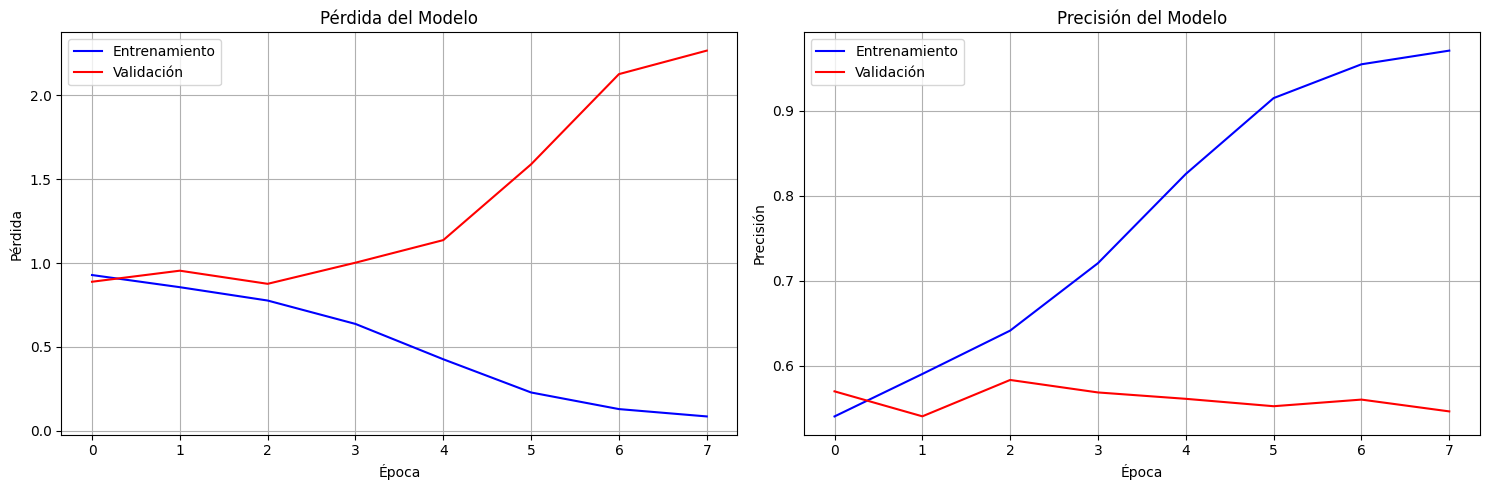

In [ ]:
# === FUNCIÓN 9: Visualización de resultados ===

def plot_training_history(history):
    """
    Grafica métricas de entrenamiento vs validación.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Pérdida
    ax1.plot(history.history['loss'], label='Entrenamiento', color='blue')
    ax1.plot(history.history['val_loss'], label='Validación', color='red')
    ax1.set_title('Pérdida del Modelo')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    ax1.grid(True)
    
    # Precisión
    ax2.plot(history.history['categorical_accuracy'], label='Entrenamiento', color='blue')
    ax2.plot(history.history['val_categorical_accuracy'], label='Validación', color='red')
    ax2.set_title('Precisión del Modelo')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Precisión')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Visualizar entrenamiento
plot_training_history(training_history)

In [ ]:
# === Evaluación final en datos de prueba ===
if len(chess_test_df) > 0:
    print("Creando datos de prueba...")
    X_test, y_test = create_training_arrays(chess_test_df, piece_mapping, 5000)
    
    # Evaluar modelo
    test_results = chess_cnn_model.evaluate(X_test, y_test, verbose=1)
    print(f"\nResultados en datos de prueba:")
    print(f"Pérdida: {test_results[0]:.4f}")
    print(f"Precisión: {test_results[1]:.4f}")
    
    # Predicciones de ejemplo
    sample_predictions = chess_cnn_model.predict(X_test[:5])
    print(f"\nEjemplo de predicciones:")
    class_names = ['Ventaja Blanca', 'Empate', 'Ventaja Negra']
    for i, pred in enumerate(sample_predictions):
        predicted_class = np.argmax(pred)
        confidence = pred[predicted_class]
        print(f"Posición {i+1}: {class_names[predicted_class]} (confianza: {confidence:.3f})")

Creando datos de prueba...
Procesando 5,000 posiciones...
Procesadas 0 posiciones...
Arrays finales - X: (5000, 8, 8, 12), y: (5000, 3)
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - categorical_accuracy: 0.5954 - loss: 0.8621 - top_k_categorical_accuracy: 1.0000

Resultados en datos de prueba:
Pérdida: 0.8621
Precisión: 0.5954
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Ejemplo de predicciones:
Posición 1: Empate (confianza: 0.374)
Posición 2: Ventaja Negra (confianza: 0.371)
Posición 3: Empate (confianza: 0.761)
Posición 4: Ventaja Blanca (confianza: 0.722)
Posición 5: Ventaja Negra (confianza: 0.668)
